First pull data from the Fannie Mae public api. Get the token by signing up at https://developer.theexchange.fanniemae.com/. Open the user drop down at the top right corner after signing in, click (Copy User Token).

In [22]:
import requests

apiUrl = 'https://api.theexchange.fanniemae.com'
econDataEndpoint = '/v1/economic-forecasts/data/years/'
year = '2018'

token = 'eyJraWQiOiJyRzhja1lKNXFnS2FwNitpVG52UWpmM1pSK1lpRG9GOFY5c1pjR1B3MGUwPSIsImFsZyI6IlJTMjU2In0.eyJjdXN0b206b3JnYW5pemF0aW9uIjoiRmFubmllIE1hZSIsInN1YiI6IjRlNDg1Y2RmLWVmMjYtNGIxNC04MzIyLWFhNDhiNjE1Y2VjZiIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJpc3MiOiJodHRwczpcL1wvY29nbml0by1pZHAudXMtZWFzdC0xLmFtYXpvbmF3cy5jb21cL3VzLWVhc3QtMV9HNWpZSUxFcVgiLCJjb2duaXRvOnVzZXJuYW1lIjoiYWlkYW5fd29vZHNAZmFubmllbWFlLmNvbSIsImN1c3RvbTpqb2JfdGl0bGUiOiJXZWIgRGV2ZWxvcGVyXC9FbmdpbmVlciIsImdpdmVuX25hbWUiOiJBaWRhbiIsImF1ZCI6IjM4MGRpaXRtc2JhN2Q2MjIwaDhsc3ExYnFvIiwiZXZlbnRfaWQiOiJkMmYzYzJkOC01MjVjLTExZTktYjU2Mi0zYmU1YjNhMThkMDUiLCJ0b2tlbl91c2UiOiJpZCIsImF1dGhfdGltZSI6MTU1Mzg4OTQyNCwiZXhwIjoxNTUzODkzMDI2LCJpYXQiOjE1NTM4ODk0MjYsImZhbWlseV9uYW1lIjoiV29vZHMiLCJlbWFpbCI6ImFpZGFuX3dvb2RzQGZhbm5pZW1hZS5jb20ifQ.e2dKTU_nlyrcww1z4BixwkZoYXFd1DqWry2b7t08uaPOKsRuxg6awIo8fIVnUZL5OcP9kbAjZUqv6xb90kegD1-U6qeTakg2cfUhxQR2U2hi7GJaVncCJ9CiIBT3hBuMHLBnC-CGnwVWpMpQFhL7x8mgkGWayuPyjuWcYdLsC_bQA_-SFyPkfQtyHDilDUvRbUlWlTyDALGltcJ1e43tNiSHucd1Too-Evfay5fx0yNE0myJPFWeTef8oAs8mJI8IxKGcVvEg-M_eC04SONi-dBHwWN_spC0tBYFxZzVQ2ttwAjeCyexWWp5LU1QcUamLoM7tID5bKGAP8XFeKVJrQ'

econData2018 = requests.get(apiUrl + econDataEndpoint + year, headers={'Authorization':token})

Here's a useful view of the unpacked json response. 

In [23]:
data = econData2018.json()
indicators = data[0]['indicators']['indicator']

for indicator in indicators:
    print(indicator['indicator-name']+': ', ', '.join(point['value'] for point in indicator['points']))

gross-domestic-product:  1.7, 1.9, 1.9, 1.9, 1.9
residential-fixed-investment:  3.7, 4.2, 4.1, 3.5, 3.9
business-fixed-investment:  2.7, 2.6, 2.9, 2.6, 2.7
government-consumption-and-investment:  -0.5, 1.1, 1.2, 1.2, 0.7
net-exports:  -664.2, -672.5, -693.9, -709.7, -685.1
change-in-business-inventories:  47.5, 47.5, 50.1, 50.9, 49.0
gdp-price-index:  2.4, 2.3, 2.4, 2.5, 2.4
consumer-price-index:  2.2, 2.3, 2.1, 2.0, 2.1
consumer-price-index-excl-food-and-energy:  2.0, 2.0, 2.0, 2.1, 2.0
unemployment-rate-percent:  4.5, 4.5, 4.5, 4.5, 4.5
employment-total-nonfarm-percent-change-quarterly-saar-annual-q4-q4:  1.2, 1.1, 1.0, 1.1, 1.1
federal-funds-rate:  1.1, 1.2, 1.4, 1.4, 1.3
1-year-treasury-note-yield:  1.6, 1.8, 1.9, 2.0, 1.8
10-year-treasury-bond-yield:  2.7, 2.7, 2.8, 2.8, 2.8


Now we need a training data set and a test set. Let's use the first available 12 years of data (2003-2014) for training, which will give us 60 data points for each indicator. We'll use the remaining 4 years (2015-2018) for our test set.

In [57]:
trainResponses = [requests.get(apiUrl + econDataEndpoint + str(year), headers={'Authorization':token})
    for year in range (2003,2015)]
    
testResponses = [requests.get(apiUrl + econDataEndpoint + str(year), headers={'Authorization':token})
    for year in range (2015,2019)]

We're going to predict Gross Domestic Product using just one of our possible features. Let's pull and plot GDP and Business Fixed Investment to see if there's a relationship we may be able to exploit.

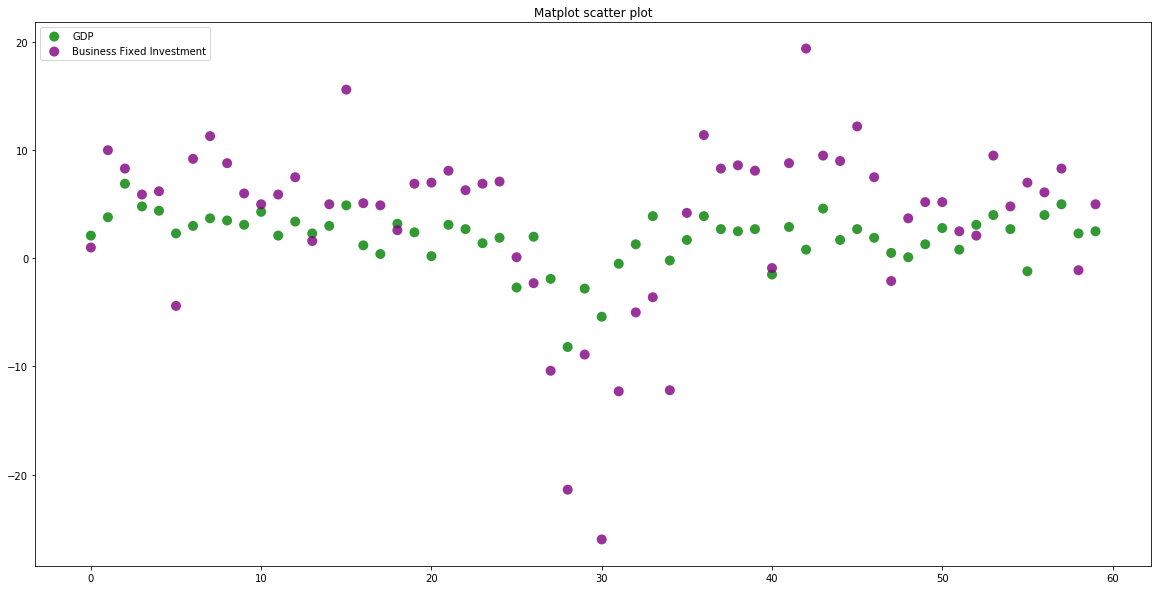

In [80]:
import numpy as np
import matplotlib.pyplot as plt

trainIndicators = [response.json()[0]['indicators']['indicator'] for response in trainResponses]
testIndicators = [response.json()[0]['indicators']['indicator'] for response in testResponses]

def getData(indicatorList, indicatorNme):
    return np.array([[[float(point['value']) for point in indic['points']]
                         for indic in indicators if indic['indicator-name']==indicatorNme] 
                         for indicators in indicatorList]).flatten()

trainGdpData = getData(trainIndicators, 'gross-domestic-product')

trainBusInvstmtData = getData(trainIndicators, 'business-fixed-investment')

testGdpData = getData(testIndicators, 'gross-domestic-product')

testBusInvstmtData = getData(testIndicators, 'business-fixed-investment')

#plot training data
groups = ('GDP','Business Fixed Investment')
colors = ('green','purple')
data = (trainGdpData,trainBusInvstmtData)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    y = data
    x = [i for i, _ in enumerate(data)]
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=100, label=group)
 
plt.title('GDP vs.Business Fixed Investment')
plt.legend(loc=2)
plt.show()


There seems to be a somewhat linear relationship between these two variables. This characteristic may make these variables a good candidate for linear regression. So, let's use scikit-learn to perform linear regression. The predictor that we obtain will allow us to get an estimate of future values that we can measure against our test set. We will train with default least squares regression.

In [83]:
!pip install sklearn

  Running setup.py bdist_wheel for sklearn: started
  Running setup.py bdist_wheel for sklearn: finished with status 'done'
  Stored in directory: C:\Users\Aidan\AppData\Local\pip\Cache\wheels\76\03\bb\589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


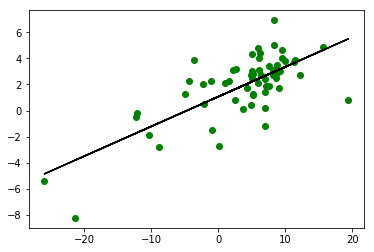

In [108]:
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()
regression_model.fit(trainBusInvstmtData.reshape(-1,1),trainGdpData)

plt.scatter(trainBusInvstmtData, trainGdpData, color='g')
plt.plot(trainBusInvstmtData, regression_model.predict(trainBusInvstmtData.reshape(-1,1)),color='k')

The linear regression has successfully captured our main axis of variance. Let's use it to predict some data for 2015. We will feed in business investment data for 2015 and compare the prediction against our true gdp for 2015.

In [113]:
busInvstmt2015 = testBusInvstmtData[:5]
gdp2015 = testGdpData[:5]

predictions2015 = regression_model.predict(busInvstmt2015.reshape(-1,1))

print(predictions2015)
print(gdp2015)

[1.36981597 1.43814797 1.9620266  0.32205872 1.25592932]
[2.  2.6 2.  0.9 1.9]


As one last step let's calculate mean squared error for our entire test set. This will give us a numerical score for how well our predictor has performed on our test sample.

In [122]:
predictions = regression_model.predict(testBusInvstmtData.reshape(-1,1))

squaredError = 0
for y,yhat in zip(testGdpData,predictions):
    squaredError += (y - yhat)**2 

meanSquaredError = squaredError/testGdpData.size

print(meanSquaredError)

0.42920079713151393


From here you can try different things and evaluate how well your model is performing. 

Feature selection:
-You can try choosing completely different features (e.g. predict gdp with unemployment rate instead of business investment) and try with more than one feature (multiple regression). 
-For more principled ways of doing feature selection, look into multiple regression variable analysis. You can also do principle component analysis to find the variables which best capture the variance of your data.

Model selection:
-There are many types of regression that we could have used to find a predictor. Linear regression is simple, but has often been shown to generalize well to data outside of the training set since it avoids overfitting.
-You can research other types of regression (e.g. polynomial regression) and try them as well.